### Import the requirements

In [1]:
!pip install optuna
!pip install numpy
!pip install pandas
!pip install lightgbm
!pip install neuralforecast
!pip install statsforecast
!pip install mlforecast
!pip install openpyxl

In [2]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'  # Workaround for OpenMP conflict

In [3]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import lightgbm as lgb
from utilsforecast.losses import mae, mape, rmse
from functools import partial

from scipy.special import gamma, gammaln
from scipy.optimize import differential_evolution, minimize
from scipy.stats import bootstrap
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from neuralforecast import NeuralForecast
from neuralforecast.models import GRU
from statsforecast import StatsForecast
from statsforecast.models import GARCH
import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae
from neuralforecast.losses.pytorch import DistributionLoss
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean, ExpandingMean, ExponentiallyWeightedMean
from mlforecast.target_transforms import Differences
from mlforecast.auto import AutoLightGBM, AutoMLForecast, AutoModel
from mlforecast.feature_engineering import Lags

# from google.colab import files

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


#### Load the dataset

In [106]:
df = pd.read_excel('NFI Sales.xlsx')

#### Display the first 5 rows of the dataset

In [107]:
df.head()

,Kpi Date,NFI Sales
0,2023-07-21 00:00:00,0
1,2023-10-13 00:00:00,66000
2,2023-11-06 00:00:00,25080
3,2023-11-07 00:00:00,45958
4,2023-11-13 00:00:00,28800


#### Display the last 5 rows of the dataset

In [108]:
df.tail()

,Kpi Date,NFI Sales
209,2025-10-16 00:00:00,33393
210,2025-10-17 00:00:00,61221
211,2025-10-18 00:00:00,74578
212,2025-10-19 00:00:00,11131
213,Totals,6916873


## Data Preparation and Preprocessing

#### Clean the dataset (Change the dataset to various date range & replace missing values)

In [109]:
# Delete the first (0 NFI Sales) & last row (Total) row
df = df[1:-1]

# Get rid of the negative value rows
df = df[df['NFI Sales'] >= 0]

df.tail()

,Kpi Date,NFI Sales
208,2025-10-15 00:00:00,13052
209,2025-10-16 00:00:00,33393
210,2025-10-17 00:00:00,61221
211,2025-10-18 00:00:00,74578
212,2025-10-19 00:00:00,11131


#### Fill the remaining data with 0, since we don't place candidates everyday

In [110]:
# Convert the KPI date to datetime, then fill in 0s for the remaining dates

df['Kpi Date'] = pd.to_datetime(df['Kpi Date'])
df.set_index('Kpi Date', inplace=True)

# Create a full daily date range from min to max date
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame to include all dates
df = df.reindex(full_range)

# Fill missing y values with 0
df['NFI Sales'] = df['NFI Sales'].fillna(0)

# # Reset index back to column
# df = df.reset_index()

In [111]:
# Check the length of the dataset
len(df)

738

In [112]:
df.head()

,NFI Sales
2023-10-13,66000.0
2023-10-14,0.0
2023-10-15,0.0
2023-10-16,0.0
2023-10-17,0.0


In [113]:
# Convert the dataset to different timescales (Weekly, Monthly).

# Weekly total
WEEKLY = df.resample('W').sum()

# Rename the columns
WEEKLY = WEEKLY.reset_index().rename(columns={"index": "ds", "NFI Sales": "y"})
WEEKLY['unique_id'] = "NFI Sales"
WEEKLY = WEEKLY[['unique_id', 'ds', 'y']]

# Monthly total
MONTHLY = df.resample('ME').sum()

# Rename the columns
MONTHLY = MONTHLY.reset_index().rename(columns={"index": "ds", "NFI Sales": "y"})
MONTHLY['unique_id'] = "NFI Sales"
MONTHLY = MONTHLY[['unique_id', 'ds', 'y']]

In [114]:
# Check the MONTHLY dataset
MONTHLY.head()

,unique_id,ds,y
0,NFI Sales,2023-10-31,66000.0
1,NFI Sales,2023-11-30,153958.0
2,NFI Sales,2023-12-31,185140.0
3,NFI Sales,2024-01-31,69796.0
4,NFI Sales,2024-02-29,139191.0


In [115]:
# Check the Daily dataset
DAILY = df.copy()
DAILY = DAILY.reset_index().rename(columns={"index": "ds", "NFI Sales": "y"})
DAILY['unique_id'] = "NFI Sales"
DAILY = DAILY[['unique_id', 'ds', 'y']]

DAILY.head()

,unique_id,ds,y
0,NFI Sales,2023-10-13,66000.0
1,NFI Sales,2023-10-14,0.0
2,NFI Sales,2023-10-15,0.0
3,NFI Sales,2023-10-16,0.0
4,NFI Sales,2023-10-17,0.0


# Descriptive Analysis

In [116]:
# Function to compute descriptive statistics
def compute_descriptive_stats(df, frequency_label):
    stats = {
        'Count': len(df),
        'Mean': df['y'].mean(),
        'Std. Dev.': df['y'].std(),
        'Min': df['y'].min(),
        'Max': df['y'].max(),
        'Skewness': df['y'].skew(),
        'Kurtosis': df['y'].kurtosis()
    }
    return pd.Series(stats, name=frequency_label)

# Compute statistics for each dataset
daily_stats = compute_descriptive_stats(DAILY, 'Daily NFI')
weekly_stats = compute_descriptive_stats(WEEKLY, 'Weekly NFI')
monthly_stats = compute_descriptive_stats(MONTHLY, 'Monthly NFI')

# Combine results into a single DataFrame
descriptive_stats = pd.concat([daily_stats, weekly_stats, monthly_stats], axis=1)

# Reorder the table for reporting
descriptive_stats = descriptive_stats.reindex([
    'Count', 'Mean', 'Std. Dev.', 'Min', 'Max', 'Skewness', 'Kurtosis'
])

# Display the final descriptive statistics table
print(descriptive_stats)

               Daily NFI     Weekly NFI    Monthly NFI
Count         738.000000     106.000000      25.000000
Mean         9397.998645   65431.349057  277428.920000
Std. Dev.   18723.008038   52201.270144  127808.762011
Min             0.000000       0.000000   66000.000000
Max        134304.000000  254472.000000  528515.000000
Skewness        2.361538       0.910727       0.126618
Kurtosis        6.390556       0.950280      -0.874028


#### Plot the sales (dataset)

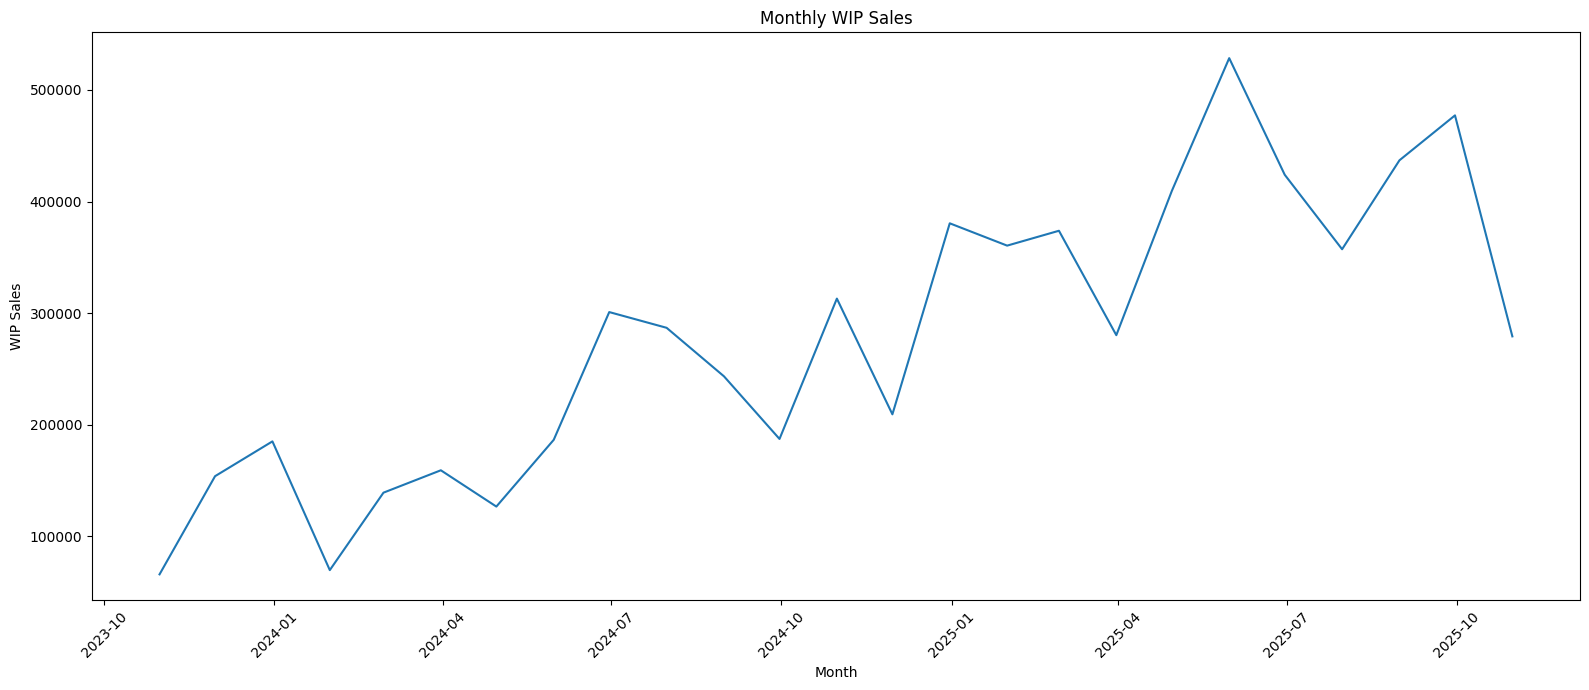

In [117]:
# Visualise the monthly sales (dataset).
fig, ax = plt.subplots(figsize=(16, 7))

# Plot the monthly sales
ax.plot(MONTHLY['ds'], MONTHLY['y'], label='y')

# Set axis labels and title
ax.set_xlabel("Month")
ax.set_ylabel("WIP Sales")
ax.set_title("Monthly WIP Sales")

# Optional: rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

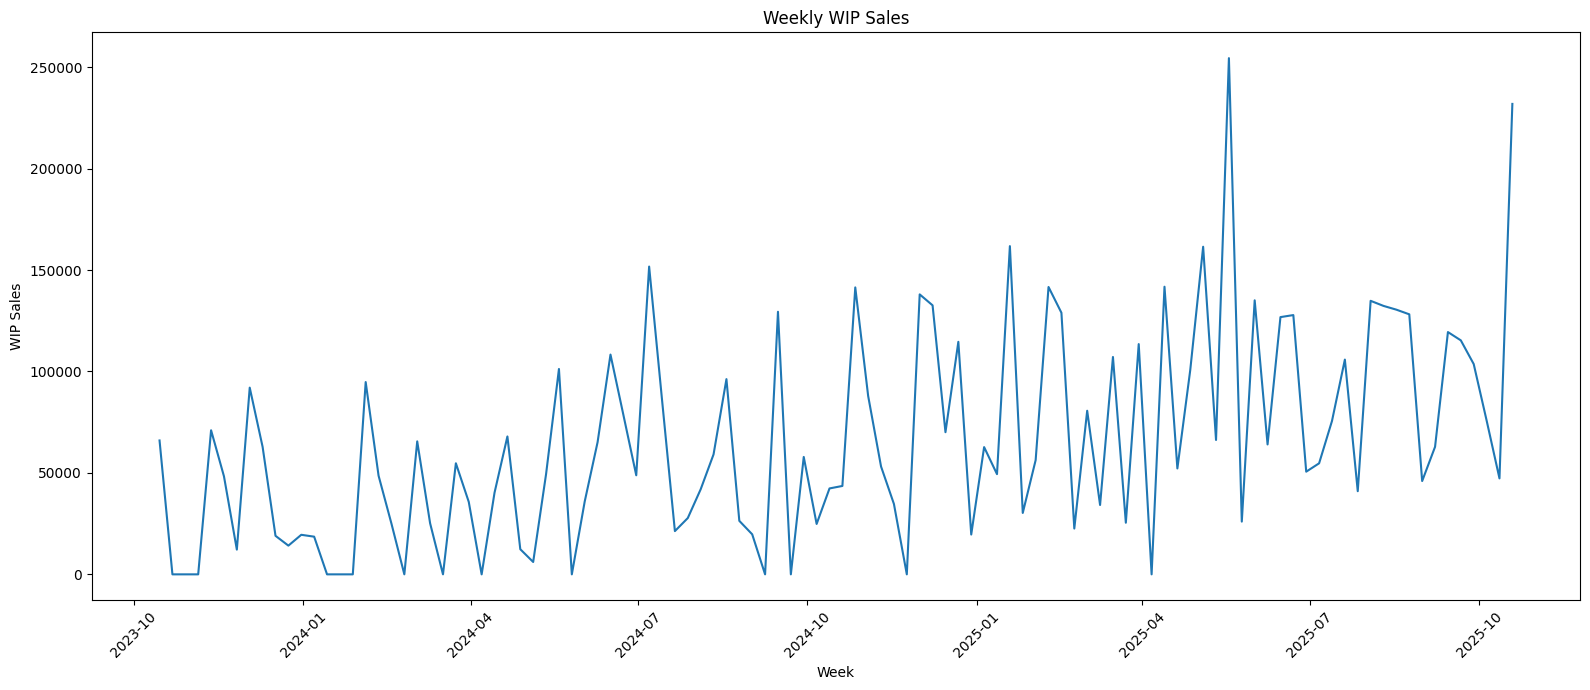

In [118]:
# Visualise the weekly sales (dataset).
fig, ax = plt.subplots(figsize=(16, 7))

# Plot the weekly sales
ax.plot(WEEKLY['ds'], WEEKLY['y'], label='y')

# Set axis labels and title
ax.set_xlabel("Week")
ax.set_ylabel("WIP Sales")
ax.set_title("Weekly WIP Sales")

# Optional: rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

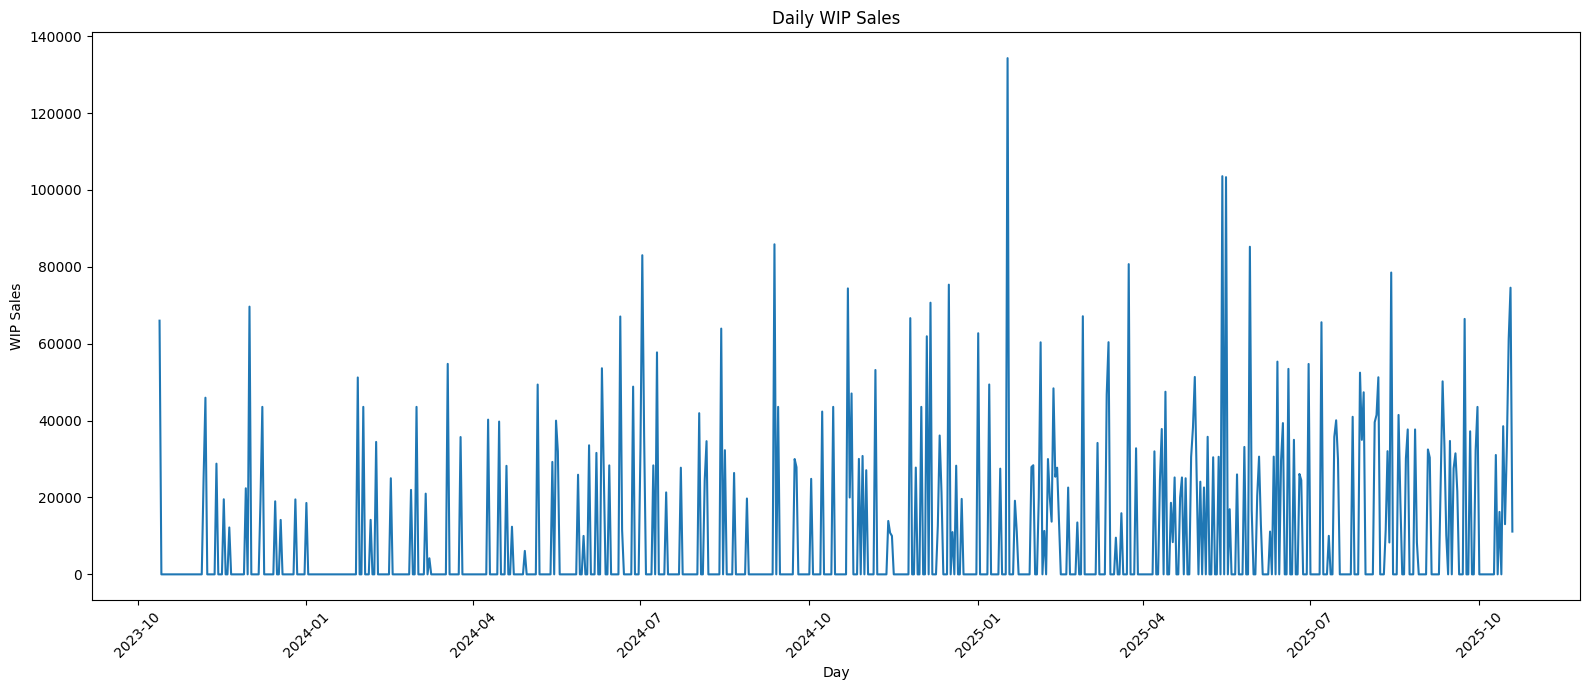

In [119]:
# Visualise the daily sales (dataset).
fig, ax = plt.subplots(figsize=(16, 7))

# Plot the daily sales
ax.plot(DAILY['ds'], DAILY['y'], label='y')

# Set axis labels and title
ax.set_xlabel("Day")
ax.set_ylabel("WIP Sales")
ax.set_title("Daily WIP Sales")

# Optional: rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

#### Split the dataset into training dataset and testing dataset

In [123]:
# Split: MONTHLY data set contains 25 data points, 80% would be for training: first 20 data points, testing will be the last 5
MONTHLY_train = MONTHLY[:20]
MONTHLY_test = MONTHLY[20:]

# Split: WEEKLY data set contains 106 data points, 80% would be for training: first 85 data points, testing will be the remaining 21
WEEKLY_train = WEEKLY[:106]
WEEKLY_test = WEEKLY[106:]

# Split: Daily data set contains 738 data points, 80% would be for training: first 590 data points, testing will be the remaining 148
DAILY_train = DAILY[:590]
DAILY_test = DAILY[590:]

In [125]:
# Test the training dataset of the Monthly data
MONTHLY_train

,unique_id,ds,y
0,NFI Sales,2023-10-31,66000.0
1,NFI Sales,2023-11-30,153958.0
2,NFI Sales,2023-12-31,185140.0
3,NFI Sales,2024-01-31,69796.0
4,NFI Sales,2024-02-29,139191.0
5,NFI Sales,2024-03-31,159243.0
6,NFI Sales,2024-04-30,126728.0
7,NFI Sales,2024-05-31,186538.0
8,NFI Sales,2024-06-30,300997.0
9,NFI Sales,2024-07-31,286899.0


# Monthly Implementation

## Machine Learning Model Development on Monthly data

In [126]:
# Create a LightGBM model for monthly forecasting
MONTHLY_model_lgb = lgb.LGBMRegressor(n_estimators=20, random_state=1, verbosity=-1)

# Define the MLForecast instance with monthly frequency
MONTHLY_forecaster = MLForecast(
    models=MONTHLY_model_lgb,
    freq='ME',  # Monthly forecast
    lags=[1, 2],  # Monthly lags (e.g., 1 and 2 months ago)
)

# Fit the model using training data
MONTHLY_forecaster.fit(MONTHLY_train)

# Generate predictions
MONTHLY_lgb = MONTHLY_forecaster.predict(len(MONTHLY_test))

## Deep Learning Model (GRU) Development on Monthly data

In [ ]:
MONTHLY_GRU_model = NeuralForecast(
    models=[
        GRU(
            h=len(MONTHLY_test),       
            input_size=12,
            recurrent=True,           
            max_steps=100,             
            random_seed=1
        )
    ],
    freq='ME'
)

# Fit the model on your monthly volatility training dataset
MONTHLY_GRU_model.fit(df=MONTHLY_train)

# Forecast next 12 months using the trained model
MONTHLY_gru = MONTHLY_GRU_model.predict()

Seed set to 1


## Hybrid Model (GARCH(1, 1) - GRU) Development on Monthly data

In [ ]:
# Step 1: Fit GARCH(1,1) to training data
sf = StatsForecast(
    models=[GARCH(1,1)],
    freq='ME'
)

sf.fit(df=MONTHLY_train)

# Step 2: Get in-sample fitted values using forecast with fitted=True
Y_hat = sf.forecast(df=MONTHLY_train, h=1, fitted=True)

# Step 3: Get fitted values
values = sf.forecast_fitted_values()
values = values.drop('y', axis=1)

# Step 4: Merge with training data
hybrid_train = MONTHLY_train.merge(
    values.rename(columns={'GARCH(1,1)': 'garch_vol'}),
    on=['unique_id', 'ds']
)

# Fill NaN values using backward fill
hybrid_train['garch_vol'] = hybrid_train['garch_vol'].bfill()

# 6. Define GRU model using GARCH volatility as exogenous input
MONTHLY_hybrid_model = NeuralForecast(
    models=[
        GRU(
            h=len(MONTHLY_test),
            input_size=12,
            recurrent=False,
            hist_exog_list=['garch_vol'],
            scaler_type='robust',
            max_steps=100,
            random_seed=1
        )
    ],
    freq='ME'
)

# 7. Fit GRU model
MONTHLY_hybrid_model.fit(df=hybrid_train)

# 8. Predict volatility for the forecast horizon
MONTHLY_hybrid = MONTHLY_hybrid_model.predict()

### Visualise the models' forecast on the Monthly data

In [ ]:
MONTHLY_hybrid = MONTHLY_hybrid.rename(columns={'GRU': 'GARCH-GRU'})

MONTHLY_forecasts = (
    MONTHLY_lgb
    .merge(MONTHLY_gru[['ds', 'GRU']], on='ds', how='inner')
    .merge(MONTHLY_hybrid[['ds', 'GARCH-GRU']], on='ds', how='inner')
)

import matplotlib.pyplot as plt

# Merge ground truth and forecasts
plot_df = pd.concat([MONTHLY_train, MONTHLY_test], ignore_index=True)
plot_df = plot_df.merge(MONTHLY_forecasts, on='ds', how='left')

# Plot
fig, ax = plt.subplots(figsize=(18, 8))

# Plot actuals
ax.plot(plot_df['ds'], plot_df['y'], label='y', color='navy')

# Plot all forecast models
forecast_cols = ['LGBMRegressor', 'GRU', 'GARCH-GRU']
colors = ['green', 'goldenrod', 'red']

for col, c in zip(forecast_cols, colors):
    if col in plot_df.columns:
        ax.plot(plot_df['ds'], plot_df[col], label=col, color=c)

# Labels and title
ax.set_title("Monthly Forecasts")
ax.set_xlabel("Time [ds]")
ax.set_ylabel("Target [y]")
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# Weekly Implementation

## Basic GARCH Modelling on Weekly data

In [270]:
# Define GARCH models to forecast.
models = [GARCH(1,1),
          GARCH(1,2),
          GARCH(2,1),
          GARCH(2,2)
]

# Initialise StatsForecast.
sf = StatsForecast(
    models = models,
    freq = 'W',  # End of week forecast.
    n_jobs = -1  # use all cores for parallel.
)

# Train the model
sf.fit(df = WEEKLY_train)

# Forecast the model
WEEKLY_GARCH = sf.forecast(df=WEEKLY_train, h=len(WEEKLY_test), fitted=True)

## Machine Learning Model Development on Weekly data

In [271]:
# Create a LightGBM model for monthly forecasting
WEEKLY_model_lgb = lgb.LGBMRegressor(n_estimators=20, random_state=1, verbosity=-1)

# Define the MLForecast instance with monthly frequency
WEEKLY_forecaster = MLForecast(
    models=WEEKLY_model_lgb,
    freq='W',     # Weekly frequency
    lags=[1, 2],  # Weekly lags: previous 1 and 2 weeks
)

# Fit the model using training data
WEEKLY_forecaster.fit(WEEKLY_train)

# Generate predictions
WEEKLY_lgb = WEEKLY_forecaster.predict(len(WEEKLY_test))

### Deep Learning (GRU) Model Deployment on Weekly data

In [272]:
# Define the GRU model for weekly data
WEEKLY_gru_model = NeuralForecast(
    models=[
        GRU(
            h=len(WEEKLY_test),        # Forecast horizon = test set length
            input_size=len(WEEKLY_test),
            recurrent=False,           # No recurrent to remain fairness
            max_steps=100,             # Keep training quick and reasonable
            random_seed=1
        )
    ],
    freq='W'  # Weekly frequency
)

# Fit the model on your monthly volatility training dataset
WEEKLY_gru_model.fit(df=WEEKLY_train)

# Forecast next 12 months using the trained model
WEEKLY_gru = WEEKLY_gru_model.predict()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | GRU           | 363 K  | train
4 | mlp_decoder  | MLP           | 25.9 K | train
-------------------------------------------------------
388 K     Trainable params
0         Non-trainable params
388 K     Total params
1.555     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

## Hybrid Model (GARCH(1, 1) - GRU) Development on Weekly data

In [273]:
# Step 1: Fit GARCH(1,1) to training data
sf = StatsForecast(
    models=[GARCH(1,1)],
    freq='W'
)

sf.fit(df=WEEKLY_train)

# Step 2: Get in-sample fitted values using forecast with fitted=True
Y_hat = sf.forecast(df=WEEKLY_train, h=1, fitted=True)  # Need to run forecast with fitted=True first

# Step 3: Get fitted values
values = sf.forecast_fitted_values()
values = values.drop('y', axis=1)

# Step 4: Merge with training data
hybrid_train = WEEKLY_train.merge(
    values.rename(columns={'GARCH(1,1)': 'garch_vol'}),
    on=['unique_id', 'ds']
)

# Fill NaN values using backward fill
hybrid_train['garch_vol'] = hybrid_train['garch_vol'].bfill()

# 6. Define GRU model using GARCH volatility as exogenous input
WEEKLY_hybrid_model = NeuralForecast(
    models=[
        GRU(
            h=len(WEEKLY_test),
            input_size=len(WEEKLY_test),
            recurrent=False,
            hist_exog_list=['garch_vol'],
            scaler_type='robust',
            max_steps=100,
            random_seed=1
        )
    ],
    freq='W'
)

# 7. Fit GRU model
WEEKLY_hybrid_model.fit(df=hybrid_train)

# 8. Predict volatility for the forecast horizon
WEEKLY_hybrid = WEEKLY_hybrid_model.predict()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | GRU           | 363 K  | train
4 | mlp_decoder  | MLP           | 25.9 K | train
-------------------------------------------------------
389 K     Trainable params
0         Non-trainable params
389 K     Total params
1.558     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

### Visualise the models' forecast on the Weekly data

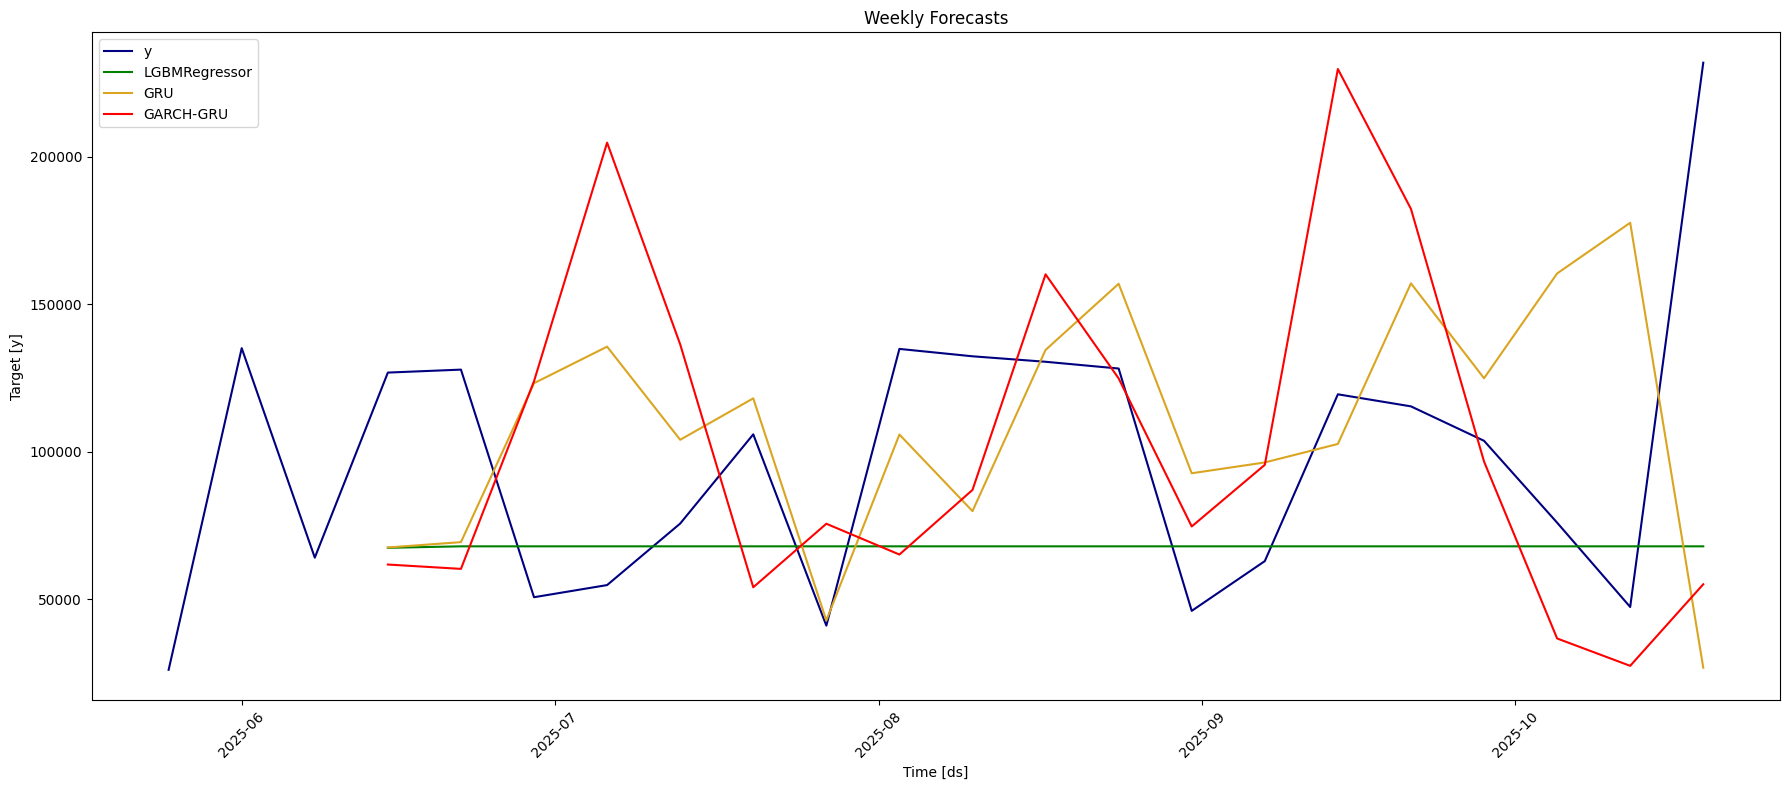

In [296]:
WEEKLY_hybrid = WEEKLY_hybrid.rename(columns={'GRU': 'GARCH-GRU'})

WEEKLY_forecasts = (
    WEEKLY_GARCH
    .merge(WEEKLY_lgb[['ds', 'LGBMRegressor']], on='ds', how='inner')
    .merge(WEEKLY_gru[['ds', 'GRU']], on='ds', how='inner')
    .merge(WEEKLY_hybrid[['ds', 'GARCH-GRU']], on='ds', how='inner')
)

# Merge ground truth and forecasts
plot_df = pd.concat([WEEKLY_train[-3:], WEEKLY_test], ignore_index=True)
plot_df = plot_df.merge(WEEKLY_forecasts, on='ds', how='left')

# Plot
fig, ax = plt.subplots(figsize=(18, 8))

# Plot actuals
ax.plot(plot_df['ds'], plot_df['y'], label='y', color='navy')

# Plot all forecast models
forecast_cols = ['LGBMRegressor', 'GRU', 'GARCH-GRU']
colors = ['green', 'goldenrod', 'red']

for col, c in zip(forecast_cols, colors):
    if col in plot_df.columns:
        ax.plot(plot_df['ds'], plot_df[col], label=col, color=c)

# Labels and title
ax.set_title("Weekly Forecasts")
ax.set_xlabel("Time [ds]")
ax.set_ylabel("Target [y]")
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

# DAILY Implementation

## Basic GARCH Modelling

In [275]:
# Define GARCH models to forecast.
models = [GARCH(1,1),
          GARCH(1,2),
          GARCH(2,1),
          GARCH(2,2)
]

# Initialise StatsForecast.
sf = StatsForecast(
    models = models,
    freq = 'C',  # End of day forecast.
    n_jobs = -1  # use all cores for parallel.
)

# Train models
sf.fit(df = DAILY_train)

# Forecast the models
DAILY_GARCH = sf.forecast(df=DAILY_train, h=len(DAILY_test), fitted=True)

## Machine Learning (LightGBM) Model Development

In [276]:
# Create a LightGBM model for daily forecasting
DAILY_model_lgb = lgb.LGBMRegressor(n_estimators=20, random_state=1, verbosity=-1)

# Define the MLForecast instance with daily frequency
DAILY_forecaster = MLForecast(
    models=DAILY_model_lgb,
    freq='C',     # Daily frequency
    lags=[1, 2],  # Daily lags: previous 1 and 2 days
)

# Fit the model using training data
DAILY_forecaster.fit(DAILY_train)

# Generate predictions
DAILY_lgb = DAILY_forecaster.predict(len(DAILY_test))

## Deep Learning (GRU) Model Development

In [277]:
# Define the GRU model for daily data
DAILY_gru_model = NeuralForecast(
    models=[
        GRU(
            h=len(DAILY_test),         # Forecast horizon = test set length
            input_size=len(DAILY_test),
            recurrent=False,           # No recurrent to remain fairness
            max_steps=100,             # Keep training quick and reasonable
            random_seed=1
        )
    ],
    freq='C'  # Daily frequency
)

# Fit the model using your daily training dataset
DAILY_gru_model.fit(df=DAILY_train)

# Forecast using the trained model and daily test set
DAILY_gru = DAILY_gru_model.predict()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | GRU           | 363 K  | train
4 | mlp_decoder  | MLP           | 25.9 K | train
-------------------------------------------------------
388 K     Trainable params
0         Non-trainable params
388 K     Total params
1.555     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

## Hybrid Model Implementation

In [278]:
# Step 1: Fit GARCH(1,1) to training data
sf = StatsForecast(
    models=[GARCH(1,1)],
    freq='C'
)

sf.fit(df=DAILY_train)

# Step 2: Get in-sample fitted values using forecast with fitted=True
Y_hat = sf.forecast(df=DAILY_train, h=1, fitted=True)  # Need to run forecast with fitted=True first

# Step 3: Get fitted values
values = sf.forecast_fitted_values()
values = values.drop('y', axis=1)

# Step 4: Merge with training data
hybrid_train = DAILY_train.merge(
    values.rename(columns={'GARCH(1,1)': 'garch_vol'}),
    on=['unique_id', 'ds']
)

# Fill NaN values using backward fill
hybrid_train['garch_vol'] = hybrid_train['garch_vol'].bfill()

# 6. Define GRU model using GARCH volatility as exogenous input
DAILY_hybrid_model = NeuralForecast(
    models=[
        GRU(
            h=len(DAILY_test),
            input_size=len(DAILY_test),
            recurrent=False,
            hist_exog_list=['garch_vol'],
            scaler_type='robust',
            max_steps=100,
            random_seed=1
        )
    ],
    freq='C'
)

# 7. Fit GRU model
DAILY_hybrid_model.fit(df=hybrid_train)

# 8. Predict volatility for the forecast horizon
DAILY_hybrid = DAILY_hybrid_model.predict()

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | hist_encoder | GRU           | 363 K  | train
4 | mlp_decoder  | MLP           | 25.9 K | train
-------------------------------------------------------
389 K     Trainable params
0         Non-trainable params
389 K     Total params
1.558     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                             | 0/? [00:00<?, ?it/s]

### Visualise the models' forecast on the Daily data

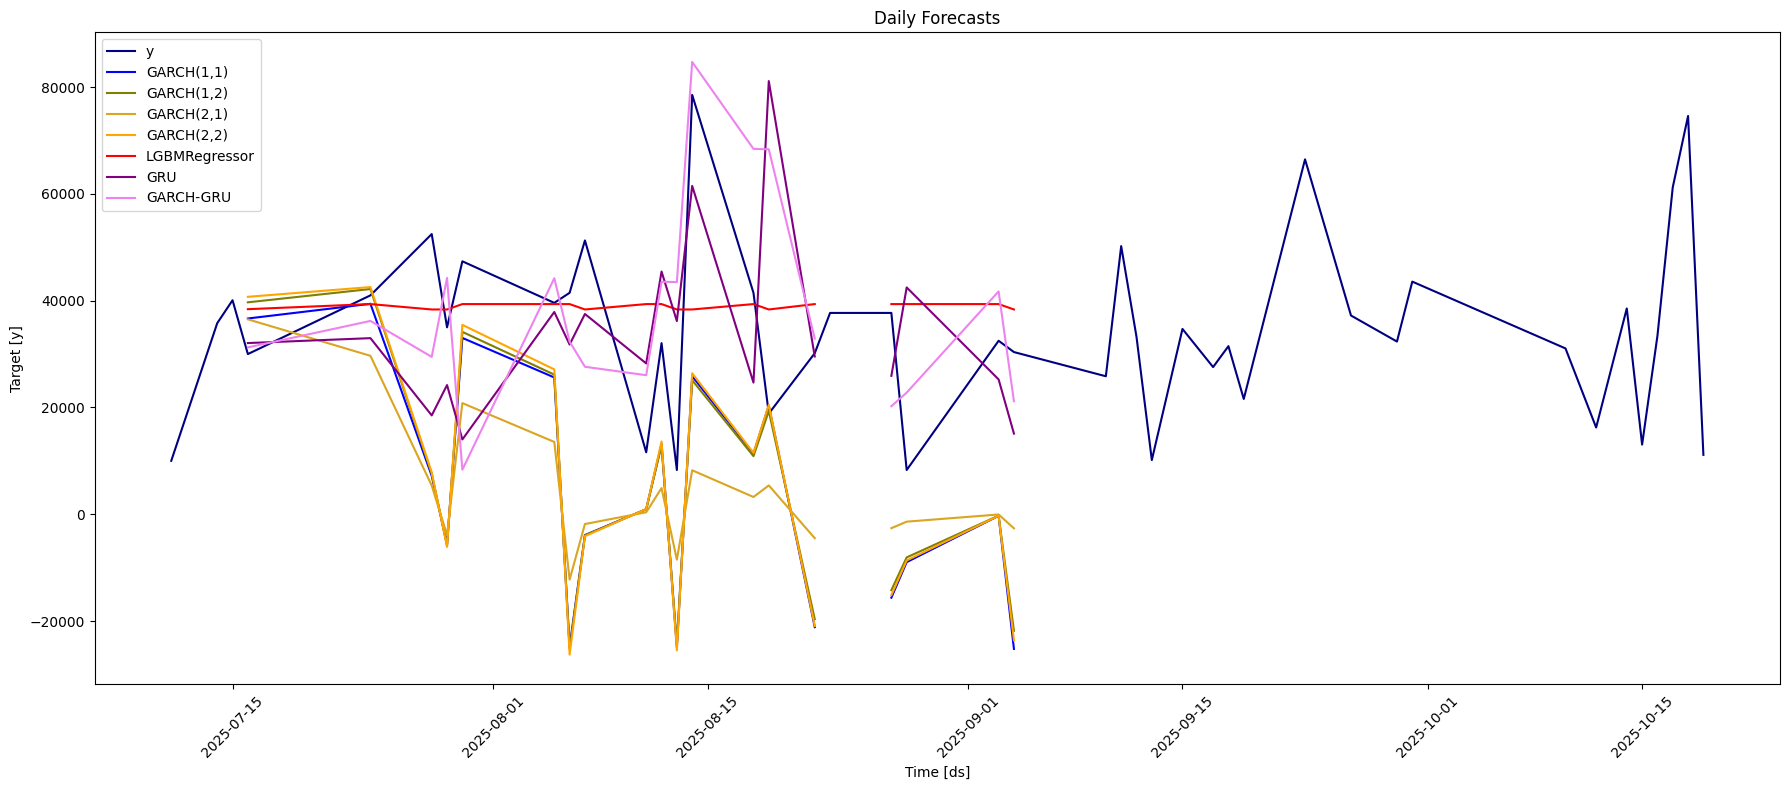

In [285]:
DAILY_hybrid = DAILY_hybrid.rename(columns={'GRU': 'GARCH-GRU'})

DAILY_forecasts = (
    DAILY_GARCH
    .merge(DAILY_lgb[['ds', 'LGBMRegressor']], on='ds', how='inner')
    .merge(DAILY_gru[['ds', 'GRU']], on='ds', how='inner')
    .merge(DAILY_hybrid[['ds', 'GARCH-GRU']], on='ds', how='inner')
)

# Merge ground truth and forecasts
plot_df = pd.concat([DAILY_train[-3:], DAILY_test], ignore_index=True)
plot_df = plot_df.merge(DAILY_forecasts, on='ds', how='left')

# Plot
fig, ax = plt.subplots(figsize=(18, 8))

# Plot actuals
ax.plot(plot_df['ds'], plot_df['y'], label='y', color='navy')

# Plot all forecast models
forecast_cols = ['GARCH(1,1)', 'GARCH(1,2)', 'GARCH(2,1)', 'GARCH(2,2)',
                 'LGBMRegressor', 'GRU', 'GARCH-GRU']
colors = ['blue', 'olive', 'goldenrod', 'orange', 'red', 'purple', 'violet']

for col, c in zip(forecast_cols, colors):
    if col in plot_df.columns:
        ax.plot(plot_df['ds'], plot_df[col], label=col, color=c)

# Labels and title
ax.set_title("Daily Forecasts")
ax.set_xlabel("Time [ds]")
ax.set_ylabel("Target [y]")
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

## Evaluate the models

In [280]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def combine_forecasts(*model_preds, model_names):
    all_dfs = []
    model_name_index = 0

    for df in model_preds:
        df = df.copy()
        forecast_cols = [col for col in df.columns if col not in ['unique_id', 'ds']]

        if len(forecast_cols) == 1:
            # Single model
            df = df.rename(columns={forecast_cols[0]: 'y_hat'})
            df['model'] = model_names[model_name_index]
            model_name_index += 1
            all_dfs.append(df[['unique_id', 'ds', 'y_hat', 'model']])
        else:
            # Multiple models in one DataFrame
            for col in forecast_cols:
                tmp = df[['unique_id', 'ds', col]].copy()
                tmp = tmp.rename(columns={col: 'y_hat'})
                tmp['model'] = model_names[model_name_index]
                model_name_index += 1
                all_dfs.append(tmp)

    return pd.concat(all_dfs, axis=0).reset_index(drop=True)

In [281]:
MONTHLY_forecast = combine_forecasts(
    MONTHLY_GARCH,
    MONTHLY_lgb,
    MONTHLY_gru,
    MONTHLY_hybrid,
    model_names=['GARCH(1,1)', 'GARCH(1,2)', 'GARCH(2,1)', 'GARCH(2,2)', 'LightGBM', 'GRU', 'GARCH-GRU']
)

WEEKLY_forecast = combine_forecasts(
    WEEKLY_GARCH,
    WEEKLY_lgb,
    WEEKLY_gru,
    WEEKLY_hybrid,
    model_names=['GARCH(1,1)', 'GARCH(1,2)', 'GARCH(2,1)', 'GARCH(2,2)', 'LightGBM', 'GRU', 'GARCH-GRU']
)

DAILY_forecast = combine_forecasts(
    DAILY_GARCH,
    DAILY_lgb,
    DAILY_gru,
    DAILY_hybrid,
    model_names=['GARCH(1,1)', 'GARCH(1,2)', 'GARCH(2,1)', 'GARCH(2,2)', 'LightGBM', 'GRU', 'GARCH-GRU']
)

In [286]:
def rank_all_models_by_frequency(train_dict, test_dict, forecasts_dict, seasonality_dict):
    rankings = {}

    for freq in ['M', 'W', 'D']:

        # Get corresponding data
        train = train_dict[freq].copy()
        test = test_dict[freq].copy()
        forecast = forecasts_dict[freq].copy()
        season_length = seasonality_dict[freq]

        # Merge actuals and predictions
        merged = test.merge(forecast, on=['unique_id', 'ds'], how='inner')

        # Ensure numeric
        merged['y'] = pd.to_numeric(merged['y'], errors='coerce')
        merged['y_hat'] = pd.to_numeric(merged['y_hat'], errors='coerce')

        # Pivot to wide format
        pivoted = merged.pivot(index=['unique_id', 'ds', 'y'], columns='model', values='y_hat').reset_index()
        pivoted.columns.name = None

        # Identify model names
        models = list(pivoted.columns.difference(['unique_id', 'ds', 'y']))

        # Evaluate
        eval_df = evaluate(
            df=pivoted,
            metrics=[
                mae,
                mape,
                rmse,
                partial(ufl.mase, seasonality=season_length),
            ],
            models=models,
            train_df=train  # Required for mase
        )

        # Determine best model per metric row
        eval_df['best_model'] = eval_df[models].idxmin(axis=1)

        # Save results
        rankings[freq] = eval_df

    return rankings

In [288]:
rankings = rank_all_models_by_frequency(
    train_dict = {'M': MONTHLY_train, 'W': WEEKLY_train, 'D': DAILY_train},
    test_dict = {'M': MONTHLY_test, 'W': WEEKLY_test, 'D': DAILY_test},
    forecasts_dict = {'M': MONTHLY_forecast, 'W': WEEKLY_forecast, 'D': DAILY_forecast},
    seasonality_dict = {'M': 1, 'W': 7, 'D': 5}
)

rankings = rank_all_models_by_frequency(
    train_dict = {'M': MONTHLY_train, 'W': WEEKLY_train, 'D': DAILY_train},
    test_dict = {'M': MONTHLY_test, 'W': WEEKLY_test, 'D': DAILY_test},
    forecasts_dict = {'M': MONTHLY_forecast, 'W': WEEKLY_forecast, 'D': DAILY_forecast},
    seasonality_dict = {'M': 1, 'W': 7, 'D': 5}
)

# View model rankings
display(rankings['M'])
display(rankings['W'])
display(rankings['D'])

,unique_id,metric,"GARCH(1,1)","GARCH(1,2)","GARCH(2,1)","GARCH(2,2)",GARCH-GRU,GRU,LightGBM,best_model
0,NFI Sales,mae,383454.518750,383807.218750,368218.306250,368230.070312,171735.775000,126910.818750,131563.600000,GRU
1,NFI Sales,mape,0.946683,0.934541,0.935906,0.935918,0.519300,0.391648,0.308743,LightGBM
2,NFI Sales,rmse,425720.531089,441739.198625,424039.856694,424042.443610,233350.554169,169604.365082,148821.399717,LightGBM
3,NFI Sales,mase,5.130495,5.135214,4.926639,4.926797,2.297768,1.698025,1.760277,GRU


,unique_id,metric,"GARCH(1,1)","GARCH(1,2)","GARCH(2,1)","GARCH(2,2)",GARCH-GRU,GRU,LightGBM,best_model
0,NFI Sales,mae,118061.899761,122167.238371,116737.687468,119288.051591,59634.076891,53048.333882,43738.856158,LightGBM
1,NFI Sales,mape,1.360133,1.443777,1.318643,1.379095,0.678790,0.644473,0.397969,LightGBM
2,NFI Sales,rmse,134818.405801,141540.194198,133262.966520,137530.336663,73951.408239,71142.011849,56244.471866,LightGBM
3,NFI Sales,mase,2.342488,2.423943,2.316214,2.366816,1.183211,1.052542,0.867831,LightGBM


,unique_id,metric,"GARCH(1,1)","GARCH(1,2)","GARCH(2,1)","GARCH(2,2)",GARCH-GRU,GRU,LightGBM,best_model
0,NFI Sales,mae,31638.083742,31314.666330,31074.311239,31557.000924,16398.143709,17707.581414,12339.202594,LightGBM
1,NFI Sales,mape,1.085719,1.067905,0.941509,1.087181,0.766809,0.883468,0.714185,LightGBM
2,NFI Sales,rmse,37540.572383,37127.503243,35373.806577,37438.936369,20913.444486,22955.335814,16871.168820,LightGBM
3,NFI Sales,mase,1.420618,1.406096,1.395303,1.416977,0.736312,0.795108,0.554057,LightGBM
